<a href="https://colab.research.google.com/github/nxxk23/AI-Engineer/blob/main/ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Nink**

In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/AIEngineer/ticket.csv")
df.head(5)

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
0,220711333,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Medium,Low,P4,Request,Inext Broadband,[Inext Broadband][Maintenance],R[Inext Broadband][Maintenance][Carrier],Interlink,NaN,2022-07-11 21:50:27.039832+00
1,22072423,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Medium,Low,P4,Request,NOC,[Nutanix-Cloud][VMaaS],R[Nutanix-Cloud][VMaaS][Customer],Other,NaN,2022-07-24 05:00:51.878427+00
2,22081755,BAAC : รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสาร...,รับสายลูกค้าคุณสุริยา เบอร์ 0818863505 แจ้งมีต...,Medium,Low,P4,Request,Inext Broadband,[Inext Broadband][Internet-Standard (Node)],R[Inext Broadband][Internet-Standard (Node)][C...,Other,NaN,2022-08-17 03:50:55.028628+00
3,22091574,Transform You : แจ้งขอข้อมูล Lun ดังนี้ Offsit...,"From: ""Teerayut Saowamok"" <teerayut.sa@transfo...",Low,Medium,P4,Request,NOC,[Flexpod-Cloud][VMaaS],R[Flexpod-Cloud][VMaaS][Customer],Other,NaN,2022-09-15 03:57:30.501931+00
4,22090556,GSB[SD] : แบบคำขอเปลี่ยนแปลงทรัพยากรบน GSB Clo...,From: Servicedesk <servicedesk@inetms.co.th>\n...,Low,Medium,P4,Request,MS-Cloud,[MS-Cloud][VMaaS],I[MS-Cloud][VMaaS][Customer],NaN,NaN,2022-09-05 03:26:02.189656+00


In [3]:
df.isnull().sum()

ticket_no                    0
subject                      0
description                 80
impact                       0
urgency                      0
priority                     0
ticket_type                  0
group                      297
service                  12447
channel_notification     12489
category                 56914
sub_category            206416
created_at                   0
dtype: int64

In [4]:
data = df.copy()

In [5]:
df.shape

(222489, 13)

In [18]:
%pip install pythainlp nltk

In [7]:
!pip install wordcloud

In [8]:
# Load these libraries
import json
import pprint
import pandas as pd
from io import StringIO # using StringIO to prevent ValueError
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [9]:
numerical_columns=['impact', 'urgency', 'priority', 'ticket_no',
                   'group', 'service', 'channel_notification', 'category',
                   'sub_category', 'created_at']
df.drop(columns=numerical_columns, inplace=True)
df.shape

(222489, 3)

In [10]:
df = df.dropna(subset=['description'])

In [11]:
print(df.shape)
print(df.isnull().sum())

(222409, 3)
subject        0
description    0
ticket_type    0
dtype: int64



### **Text Cleaning**

Text Cleaning: Remove unnecessary parts of the `subject` and `description`

In [12]:
import re
import email

#### **email body content**

In [13]:
def extract_email_subject(text):
    # Define the regular expression pattern
    pattern = r"[:\]]\s*(.*)"

    # Match the pattern against the text
    match = re.search(pattern, text)

    if match:
        # Extract the matched text (after the colon or bracket)
        extracted_text = match.group(1).strip()
        if extracted_text:
            return extracted_text
    return text

In [14]:
import re

def extract_email_body(text):
    # Function to handle plain text
    def extract_plain_text_body(text):
        # Heuristic for body end - find common closing phrases
        body_end_pattern = r"(?i)(\b(best regards|thanks|sincerely|see you soon|regards|ขอบคุณครับ|ขอบคุณค่ะ|Best regards)\b)"
        match = re.search(body_end_pattern, text)

        if match:
          # Get the position where the pattern matched
          end_pos = match.start()
          # Return the part of the text before the match
          return text[:end_pos].strip()
        else:
          # If pattern is not found, return the whole body
          return text.strip()

    # Function to handle email format
    def extract_email_format_body(text):
        # Find the index of the line starting with "Subject:"
        subject_index = text.find("Subject:")
        if subject_index != -1:
            # Extract the body text from the line after "Subject:"
            subject_end_index = text.find("\n", subject_index)
            if subject_end_index != -1:
              subject_line = text[subject_index:subject_end_index].strip()

              # Find all text after the "Subject:" line
              text = text[subject_end_index:].strip()
        # Delete delimiter in text
        delimiter_pattern = r"-{50,}"
        body = re.sub(delimiter_pattern, "", text)

        # Apply the same heuristic for body end
        return extract_plain_text_body(body)

    # Check for email headers to determine the format
    email_headers_pattern = r"^(From|To|Subject|Date|Message-ID):"
    if re.search(email_headers_pattern, text, re.MULTILINE):
        return extract_email_format_body(text)
    else:
        return extract_plain_text_body(text)

In [15]:
df['clean_subject'] = df['subject'].apply(extract_email_subject)

In [16]:
df['clean_description'] = df['description'].apply(extract_email_body)

#### **empty description**
```
get the subject of it instead..
cuz the email not include the body content
```

In [26]:
empty_clean_desc_indices = df[df['clean_description'] == ''].index

# Step 2: Use these indices to access the corresponding 'description' values
empty_clean_desc_descriptions = df.loc[empty_clean_desc_indices, 'description']

# If you want to print these out:
for idx in empty_clean_desc_indices:
    print(f"Index: {idx}, Description: {df.loc[idx, 'description']}")

Index: 456, Description: From: "Oralak Phalaherm" <Oralak.pha@themall.co.th>
To: "INET Network Operation" <noc@inet.co.th>
Sent: Friday, July 15, 2022 8:47:04 AM
Subject: ระบบเข้าใช้งานไม่ได้ค่ะ

 



ขอบคุณค่ะ

Regard,

Oralak (Pui)

081-875-0325

 


Index: 545, Description: From: "Oralak Phalaherm" <Oralak.pha@themall.co.th>
To: "nockkc" <nockkc@inet.co.th>
Cc: "Vipanun Pongsiritanadeach" <vipanun.po@inet.co.th>
Sent: Friday, July 15, 2022 9:05:45 AM
Subject: ONEBOX เลือกข้อมูล ประมวลผลช้ามาก เกิน 10นาที

 



 

ขอบคุณค่ะ

Regard,

Oralak (Pui)

081-875-0325

 


Index: 706, Description: From: "supawat(net)" <supawat@globalfoodproduct.com>
To: INET Network Operation <noc@inet.co.th>
Cc: -
Sent: Tuesday, 02 August 2022 00:14:56 am
Subject: รบกวนอธิบายความหมายตามภาพแนบหน่อยครับ
---------------------------------------------------
ขอบคุณครับ
Supawat(Net) - it Consultant
Global Food Products Co., Ltd.
 
1310/4 Rama 3 Road, Chongnonsri, Yannawa, Bangkok 10120
Tel :(+66) 97 110 5949 E-mai

##### **case 1:**
    ฟังก์ชัน extract body ไม่ได้ เพราะเมลล์ที่ส่งมาไม่มี body

In [29]:
df[df['clean_description'] == ''] #เกิดจาก ไม่มี body ใน email หรือ ฟังก์ชัน extract body ไม่ได้ เพราะเมลล์ที่ส่งมาไม่มี body มีอยู่ประมาณ 259 rows

,subject,description,ticket_type,clean_subject,clean_description
456,[JV-Platform][ETAX] : ระบบเข้าใช้งานไม่ได้ค่ะ,"From: ""Oralak Phalaherm"" <Oralak.pha@themall.c...",Incident,[ETAX] : ระบบเข้าใช้งานไม่ได้ค่ะ,
545,[JV-Platform][One Box] : ONEBOX เลือกข้อมูล ปร...,"From: ""Oralak Phalaherm"" <Oralak.pha@themall.c...",Incident,[One Box] : ONEBOX เลือกข้อมูล ประมวลผลช้ามาก ...,
706,Global Food Products : รบกวนอธิบายความหมายตามภ...,"From: ""supawat(net)"" <supawat@globalfoodproduc...",Request,รบกวนอธิบายความหมายตามภาพแนบ,
831,THAI YAMAHA MOTOR : รบกวนเพิ่ม policy any 20...,From: Sarawut Miankerd <sarawut_m@yamaha-motor...,Request,รบกวนเพิ่ม policy any 203.150.111.81 port 80...,
1355,[Close][OP-SEC]THAI YAMAHA MOTOR : แจ้งขอ poli...,From: Sarawut Miankerd <sarawut_m@yamaha-motor...,Request,[OP-SEC]THAI YAMAHA MOTOR : แจ้งขอ policy fire...,
...,...,...,...,...,...
215470,Non Sa-At Hospital : แจ้งเอกสารการกรอกหลักฐานโ...,From: Supat anan <id.supat.anan@gmail.com>\nTo...,Request,แจ้งเอกสารการกรอกหลักฐานโรงพยาบาล รพ.โนนสะอาด ...,
216277,M-Focus : แจ้งไม่สามารถ receive e-mail,"From: ""Komkrich.Jaikaew@MFC"" <komkrich@m-focus...",Incident,แจ้งไม่สามารถ receive e-mail,
217062,FOOD UP 2 U : รบกวนตรวจสอบ Email เนื่องจากไม่...,From: <sirinya@foodup2u.com>\nTo: <noc@inet.co...,Incident,รบกวนตรวจสอบ Email เนื่องจากไม่ได้รับ Mail,
218561,Chakkarat Hospital : นำส่งเอกสารประเมินความเสี่ยง,From: nichapa wangomklang <gifsura@gmail.com>\...,Request,นำส่งเอกสารประเมินความเสี่ยง,


In [32]:
df.loc[df['clean_description'] == '', 'clean_description'] = df['clean_subject']

##### **case 2:**
    no subject

In [39]:
df[df['subject'] == ' '] #replace ' ' with Express Cloud - เพิ่ม Users

,subject,description,ticket_type,clean_subject,clean_description
105162,,"From: ""bot orders noreply"" <bot_orders_noreply...",Request,,เรียน เจ้าหน้าที่ไอเน็ท\n\nแจ้งการใช้บริการ Ex...
105163,,"From: ""bot orders noreply"" <bot_orders_noreply...",Request,,เรียน เจ้าหน้าที่ไอเน็ท\n\nแจ้งการใช้บริการ Ex...


In [42]:
df.loc[df['clean_subject'].str.strip() == '', 'clean_subject'] = 'Express Cloud - เพิ่ม Users'

In [43]:
df[df['subject'] == ' ']

,subject,description,ticket_type,clean_subject,clean_description
105162,,"From: ""bot orders noreply"" <bot_orders_noreply...",Request,Express Cloud - เพิ่ม Users,เรียน เจ้าหน้าที่ไอเน็ท\n\nแจ้งการใช้บริการ Ex...
105163,,"From: ""bot orders noreply"" <bot_orders_noreply...",Request,Express Cloud - เพิ่ม Users,เรียน เจ้าหน้าที่ไอเน็ท\n\nแจ้งการใช้บริการ Ex...


In [21]:
# empty_clean_sub_indices = df[df['clean_subject'] == ''].index

# # Step 2: Use these indices to access the corresponding 'subject' values
# empty_clean_sub = df.loc[empty_clean_sub_indices, 'subject']

# # If you want to print these out:
# for idx in empty_clean_sub_indices:
#     print(f"Index: {idx}, Subject: {df.loc[idx, 'subject']}")

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from pythainlp.tokenize import word_tokenize as thai_word_tokenize
from nltk.tokenize import word_tokenize as eng_word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### **unnecessary character**

In [49]:
def character(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"\S+@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"<[^>]*>", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"\"[^\"]*\"", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"\([^)]*\)", "", regex=True)

    metadata_patterns = [
        r"from:", r"to:", r"cc:", r"sent:", r"subject:", r"best regards", r"tel\.", r"mobile", r"e-mail",
        r"เรียน", r"ถึง", r"แจ้ง","วันที่", "เวลา"
    ]
    for pattern in metadata_patterns:
        df[text_field] = df[text_field].str.replace(pattern, "", regex=True)

    # Add patterns for Thai months, Thai days, English days, and formatted English dates
    thai_months = r'(มกราคม|กุมภาพันธ์|มีนาคม|เมษายน|พฤษภาคม|มิถุนายน|กรกฎาคม|สิงหาคม|กันยายน|ตุลาคม|พฤศจิกายน|ธันวาคม)'
    thai_months_short = r'(ม.ค|ก.พ|มี.ค|เม.ย|พ.ค|มิ.ย|ก.ค|ส.ค|ก.ย|ต.ค|พ.ย|ธ.ค)'
    thai_days = r'(อาทิตย์|จันทร์|อังคาร|พุธ|พฤหัสบดี|ศุกร์|เสาร์)'
    eng_days = r'(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)'
    format_eng_short = r'\b([0-9]{1,2})\s*(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s*([0-9]{4})\b' # 21Sep2000 or 21 Sep 2000

    date_patterns = [thai_months, thai_months_short, thai_days, eng_days, format_eng_short]
    for pattern in date_patterns:
        df[text_field] = df[text_field].str.replace(pattern, "", regex=True)

    df[text_field] = df[text_field].str.replace(r"\n+", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"\s+", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=False)
    df[text_field] = df[text_field].str.replace(r"!", "", regex=False)
    df[text_field] = df[text_field].str.replace(r",", "", regex=False)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9ก-๙(),!?\'\`\s]", " ", regex=True)

    # Remove digits
    df[text_field] = df[text_field].str.replace(r"\d+", "", regex=True)

    # Remove unwanted characters at the start, in between, or end of words
    df[text_field] = df[text_field].str.replace(r"(^[\-_]+|[\-_]+$|(?<=\W)[\-_]+|[\-_]+(?=\W))", " ", regex=True)

    # Convert to lowercase
    df[text_field] = df[text_field].str.lower().str.strip()

    return df

In [52]:
df = character(df, 'clean_subject')
df = character(df, 'clean_description')

In [25]:
df.head(2)

,subject,description,ticket_type,clean_subject,clean_description
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,ma น น cid inextbaac สาขา หน่วยบ...,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,promessy corporation ตรวจสอบเครื่อง ip r...,inet team เครื่อง private ip ได้มีการ rest...


In [26]:
df['description'].iloc[22222]

'05:44 LINE Notify BAAC ITEL: INEXTBAAC0393 - CE (HL-TRUE:U52691) is ❌ Down at least 5 min at 05:44:25 AM January 12, 2023'

##### **case3:**
    description หลังจากสกัดแล้วดันเป็นค่าว่าง เพราะไม่มี body ของ email เหมือนกัน

In [65]:
df[df['clean_description'].str.contains('^$')] #ใช้ clean_subject instead

,subject,description,ticket_type,clean_subject,clean_description
246,JV-One Authen (Digital Signature) : Noc ได้รั...,"\n​​​----- Original Message -----\n​​​​From: ""...",Incident,noc ได้รับ alert jv one authen statusslow resp...,
419,JV-One Authen : NOC ได้รับ Alert [CN0-000369] ...,"\n​​​----- Original Message -----\n​​​​From: ""...",Incident,noc ได้รับ alert cn jv one authen monitorst...,
522,JV-One Authen (Digital Signature) : NOC ได้รับ...,"\n​​​----- Original Message -----\n​​​​From: ""...",Incident,noc ได้รับ alert jv one authen เมื่อ novem...,
2954,[Closed][OP-NW]Minor : NOC Monitor พบ IP 168.6...,168.63.240.153 \n52.113.194.132\n52.113.195.13...,Incident,op nw minor noc monitor พบ ip ...,
2963,Best Western Hotels : พบปัญหา Email account l...,From: Pasin Dangsaeard <Pasin.Dangsaeard@bestw...,Incident,พบปัญหา email account lockout บ่อย,
...,...,...,...,...,...
221786,One Authen : Digital Signature : NOC ได้รับ Al...,\n\n​​​----- Original Message -----\n​​​​From:...,Incident,digital signature noc ได้รับ alert jv one ...,
221788,MOPH Digital Signature : NOC ได้รับ Alert : JV...,"----- Original Message -----\n​​​​From: ""OneAu...",Incident,noc ได้รับ alert jv one authen morprompt dig...,
221792,CI_One Authen : Digital Signature : NOC ได้รับ...,\n\n​​​----- Original Message -----\n​​​​From:...,Incident,digital signature noc ได้รับ alert jv one au...,
222126,CI_One Authen : Digital Signature : noc ได้รับ...,"\n​​​----- Original Message -----\n​​​​From: ""...",Incident,digital signature noc ได้รับ alet cn jv o...,


In [66]:
df.loc[df['clean_description'] == '', 'clean_description'] = df['clean_subject']

##### **case 4:**

In [68]:
df[df['clean_description'].str.contains('^$')] #drop

,subject,description,ticket_type,clean_subject,clean_description
212754,-,-,Request,,


In [69]:
df = df[~df['clean_description'].str.strip().str.match('^$')]

##### **case 5:**

In [71]:
df[df['clean_subject'].str.contains('^$')]

,subject,description,ticket_type,clean_subject,clean_description
2434,Resend เอกสาร 15/07/2022 บริษัท ชิคเก้นไทม์ จำ...,"From: ""Arunothai Thongphan"" <arunothai_th@mino...",Request,,เจ้าหน้าที่ รบกวน resend เอกสาร ใบกำกับภาษี ...
36774,2. ลูกค้า JV แจ้งปัญหาผ่าน Email : nockkc@inet...,2.1 .ลูกค้าสามารถติดต่อเข้ามา ทาง Email : nock...,Incident,,ลูกค้าสามารถติดต่อเข้ามา ทาง email noc รับ...
36946,1. ลูกค้า INET แจ้งปัญหาผ่าน Email : noc@inet....,From: Pongsatorn Sanamlao <pongsatorn.sa@inet....,Request,,ลูกค้า inet ปัญหาผ่าน email
55062,ขอเข้าพื้นที่ IDC2 เพื่อดำเนินการ Replace Dis...,\n ขอเข้าพื้นที่ IDC2 เพื่อดำเนินกา...,Request,,ขอเข้าพื้นที่ idc เพื่อดำเนินการ replace disk ...
95608,Noc monitor พบ INEXT-NW_BranchVRF_24267_DAISI...,21:19:36\t\t\t\tPROBLEM\t\t-_INEXT-NW_BranchVR...,Incident,,problem inext nw branchvrf daisin nava ui...
118065,เข้าไปเยี่ยมชม IDC2 เพื่อดูกระบวนการเข้าพื้นที...,"จาก: ""Monchanok Moonsarn"" <monchanokm@inet.co....",Request,,จาก ส่งแล้ว pm เรื่อง ขอเข้าไปเยี่...
173602,รายงานตรวจสอบสถานะไฟอุปกรณ์ NX-Cloud IDC2 วันท...,รายงานตรวจสอบสถานะไฟอุปกรณ์ NX-Cloud IDC2 วันท...,Problem,,รายงานตรวจสอบสถานะไฟอุปกรณ์ nx cloud idc รา...
185632,ลากสายแก้ Incident อ้างอิง Ticket INET : 24012...,"From: ""Boontharika Jaesurapap"" <boontharika.ja...",Request,,พี่ปีเตอร์ ขออนุญาตดำเนินการลากสายด่วนในส่วนขอ...
200772,ลากสายแก้ Incident อ้างอิง Ticket INET : 24012...,"From: ""Boontharika Jaesurapap"" <boontharika.ja...",Request,,พี่ปีเตอร์ ขออนุญาตดำเนินการลากสายด่วนในส่วนขอ...
205162,Hospital-SOMDEJ [SOC] :,"From: ""servicedesk@inetms.co.th"" <servicedesk@...",Incident,,alert suspicious activity rdp access from s...


In [76]:
df.loc[df['clean_subject'] == '', 'clean_subject'] = df['clean_description']

In [77]:
df[df['clean_subject']=='']

,subject,description,ticket_type,clean_subject,clean_description


### **Tokenizing**

In [ ]:
#%pip install --upgrade transformers

In [ ]:
# from transformers import CamembertTokenizer

# # Load pre-trained Thai BERT tokenizer
# model_name = 'airesearch/wangchanberta-base-att-spm-uncased'
# tokenizer = CamembertTokenizer.from_pretrained(model_name)

In [ ]:
# # Ensure all descriptions and subjects are strings
# df['clean_subject'] = df['clean_subject'].astype(str)
# df['clean_description'] = df['clean_description'].astype(str)

# # Tokenize the 'subject' and 'description' columns
# df['token_subject'] = df['clean_subject'].apply(lambda x: tokenizer.encode(x, truncation=False))
# df['token_description'] = df['clean_description'].apply(lambda x: tokenizer.encode(x, truncation=False))

In [79]:
# Tokenize word function
def tokenize(text):
    thai_tokens = thai_word_tokenize(text, keep_whitespace=False)
    eng_tokens = eng_word_tokenize(text)
    return thai_tokens + eng_tokens

In [80]:
df['tokenized_subject'] = df['clean_subject'].apply(tokenize)
df['tokenized_description'] = df['clean_description'].apply(tokenize)

<ipython-input-80-4cbacf70e767>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_subject'] = df['clean_subject'].apply(tokenize)
<ipython-input-80-4cbacf70e767>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_description'] = df['clean_description'].apply(tokenize)


In [ ]:
df['clean_subject'].iloc[0]

'ma     น  -   น   cid  inextbaac   สาขา หน่วยบุรีรัมย์'

In [ ]:
df['tokenized_subject'].iloc[0]

['ma',
 'น',
 '-',
 'น',
 'cid',
 'inextbaac',
 'สาขา',
 'หน่วย',
 'บุรีรัมย์',
 'ma',
 'น',
 '-',
 'น',
 'cid',
 'inextbaac',
 'สาขา',
 'หน่วยบุรีรัมย์']

#### **spell correction**

In [ ]:
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=a8d170c4f86ecc31fd3f3778709d23d7e3995ea31940a48fba7a5c30ac36f7c5
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [ ]:
!wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt -O frequency_dictionary_en_82_765.txt

--2024-06-26 05:30:31--  https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332881 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt’

frequency_dictionar 100%[===================>]   1.27M  --.-KB/s    in 0.06s   

2024-06-26 05:30:31 (20.8 MB/s) - ‘frequency_dictionary_en_82_765.txt’ saved [1332881/1332881]



> **thai word only**

In [ ]:
!pip install thaispellcheck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00


In [ ]:
from pythainlp.spell import correct as correct_thai

# Function to correct Thai words using pythainlp
def correct_thai_words(tokens):
    corrected_tokens = []
    for token in tokens:
        # Check if the token is Thai
        if any(ord(char) >= 0x0E00 and ord(char) <= 0x0E7F for char in token):
            # Correct Thai word using pythainlp
            corrected_word = correct_thai(token)
            corrected_tokens.append(corrected_word)
        else:
            corrected_tokens.append(token)  # Keep non-Thai tokens unchanged
    return corrected_tokens

In [ ]:
# Apply the correct spelling function to each row in the DataFrame
df['correct_subject'] = df['tokenized_subject'].apply(correct_thai_words)
df['correct_description'] = df['tokenized_description'].apply(correct_thai_words)

#### **cut the meaningless words**

In [81]:
import pandas as pd
from nltk.corpus import stopwords as en_stopwords
import nltk
from pythainlp.corpus import thai_stopwords

nltk.download('stopwords')

stop_words_th = set(thai_stopwords())
stop_words_en = set(en_stopwords.words('english'))

# Add Thai characters 'ก' to 'ฮ' to the Thai stop words set
thai_alphabet = [chr(i) for i in range(ord('ก'), ord('ฮ') + 1)]
# List of Thai vowels and tone marks
thai_vowels_and_tone_marks = ['ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', 'ๅ', '็', '่', '้', '๊', '๋', '์', 'ํ']

stop_words_th.update(thai_alphabet)
stop_words_th.update(thai_vowels_and_tone_marks)

combined_stop_words = stop_words_th.union(stop_words_en)

# Function to remove stop words and duplicates
def remove_stop_words_and_duplicates(tokens, stop_words):
    return list(set(token for token in tokens if token.lower() not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [82]:
len(stop_words_th), len(stop_words_en)

(1098, 179)

In [83]:
# Apply function to tokenized columns and remove duplicates
df['meaning_subject'] = df['tokenized_subject'].apply(lambda tokens: remove_stop_words_and_duplicates(tokens, combined_stop_words))
df['meaning_description'] = df['tokenized_description'].apply(lambda tokens: remove_stop_words_and_duplicates(tokens, combined_stop_words))

<ipython-input-83-35ded6320336>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['meaning_subject'] = df['tokenized_subject'].apply(lambda tokens: remove_stop_words_and_duplicates(tokens, combined_stop_words))
<ipython-input-83-35ded6320336>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['meaning_description'] = df['tokenized_description'].apply(lambda tokens: remove_stop_words_and_duplicates(tokens, combined_stop_words))


In [85]:
print(len(df['tokenized_description'].loc[4]), (df['tokenized_description'].loc[4]))

85 ['noc', 'ครับ', 'subject', 'internal', 'gsb', 'sr', 'รับ', 'รล', 'แบบ', 'คำขอ', 'เปลี่ยนแปลง', 'ทรัพยากร', 'บน', 'gsb', 'cloud', 'based', 'services', 'gateway', 'กรมการปกครอง', 'ต่อ', 'อายุการใช้งาน', 'ฝ่าย', 'วางแผน', 'เทคโนโลยีสารสนเทศ', 'ธนาคารออมสิน', 'ส่ง', 'แบบ', 'คำขอ', 'เปลี่ยนแปลง', 'ทรัพยากร', 'บน', 'gsb', 'cloud', 'based', 'services', 'gateway', 'กรมการปกครอง', 'ต่อ', 'อายุการใช้งาน', 'รบกวน', 'ดำเนินการ', 'ให้', 'ด้วย', 'ครับ', 'เบื้องต้น', 'กำลัง', 'ประสานงาน', 'ทาง', 'ทีม', 'sale', 'ดำเนินการ', 'approve', 'เรียบร้อย', 'ครับ', 'noc', 'ครับ', 'subject', 'internal', 'gsb', 'sr', 'รับ', 'รล', 'แบบคำขอเปลี่ยนแปลงทรัพยากรบน', 'gsb', 'cloud', 'based', 'services', 'gateway', 'กรมการปกครอง', 'ต่ออายุการใช้งาน', 'ฝ่ายวางแผนเทคโนโลยีสารสนเทศ', 'ธนาคารออมสิน', 'ส่งแบบคำขอเปลี่ยนแปลงทรัพยากรบน', 'gsb', 'cloud', 'based', 'services', 'gateway', 'กรมการปกครอง', 'ต่ออายุการใช้งาน', 'รบกวนดำเนินการให้ด้วยครับเบื้องต้นกำลังประสานงานทางทีม', 'sale', 'ดำเนินการ', 'approve', 'เรียบร้อยครับ'

In [84]:
print(len(df['meaning_description'].iloc[4]), (df['meaning_description'].iloc[4]))

31 ['อายุการใช้งาน', 'ทรัพยากร', 'gsb', 'gateway', 'เบื้องต้น', 'subject', 'ต่ออายุการใช้งาน', 'noc', 'กรมการปกครอง', 'services', 'based', 'ธนาคารออมสิน', 'เรียบร้อยครับ', 'sale', 'แบบคำขอเปลี่ยนแปลงทรัพยากรบน', 'เรียบร้อย', 'รบกวน', 'ทีม', 'รบกวนดำเนินการให้ด้วยครับเบื้องต้นกำลังประสานงานทางทีม', 'sr', 'รล', 'ประสานงาน', 'ส่งแบบคำขอเปลี่ยนแปลงทรัพยากรบน', 'วางแผน', 'ฝ่ายวางแผนเทคโนโลยีสารสนเทศ', 'เทคโนโลยีสารสนเทศ', 'approve', 'คำขอ', 'ดำเนินการ', 'cloud', 'internal']


```
ความยาวของ token ในคอลัมน์ description และsubject
```

In [86]:
df['meaning_description'].apply(len).describe()

count    222408.000000
mean         38.731921
std          34.063076
min           0.000000
25%          15.000000
50%          26.000000
75%          52.000000
max         610.000000
Name: meaning_description, dtype: float64

In [87]:
df['meaning_subject'].apply(len).describe()

count    222408.000000
mean         10.211355
std           4.551210
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         137.000000
Name: meaning_subject, dtype: float64

In [88]:
df

,subject,description,ticket_type,clean_subject,clean_description,tokenized_subject,tokenized_description,meaning_subject,meaning_description
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,ma น น cid inextbaac สาขา หน่วยบ...,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา...","[inextbaac, cid, สาขา, หน่วยบุรีรัมย์, บุรีรัม...","[ท่าน, สิ้นสุดดำเนินการ, ปรับปรุง, ขอจัดส่งจดห..."
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,promessy corporation ตรวจสอบเครื่อง ip r...,inet team เครื่อง private ip ได้มีการ rest...,"[promessy, corporation, ตรวจสอบ, เครื่อง, ip, ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา...","[ip, restart, ตรวจสอบเครื่อง, โดยไม่ทราบสาเหตุ...","[team, ได้มีการ, รบกวนเช็คให้หน่อยครับ, โดยไม่..."
2,BAAC : รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสาร...,รับสายลูกค้าคุณสุริยา เบอร์ 0818863505 แจ้งมีต...,Request,รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสารภี เนื่...,รับสายลูกค้าคุณสุริยา เบอร์ มีตัวกล่องอุปกรณ์...,"[รบกวน, เข้าไป, เก็บตัว, กล่อง, สัญญาณ, ที่, ส...","[รับสาย, ลูกค้า, คุณ, สุริยา, เบอร์, มี, ตัว, ...","[เข้าไป, สารภี, เนื่องจากมีการย้ายอาคารไปแล้ว,...","[เข้าไป, เดิม, โทร, เพชร, ตัว, สุภา, รับทราบ, ..."
3,Transform You : แจ้งขอข้อมูล Lun ดังนี้ Offsit...,"From: ""Teerayut Saowamok"" <teerayut.sa@transfo...",Request,ขอข้อมูล lun ดังนี้ offsite อยู่ที่ idc ไหนและ...,noc รบกวนเปิดเคสประสานงานทีม op cloud ทางทีม t...,"[ขอ, ข้อมูล, lun, ดังนี้, offsite, อยู่, ที่, ...","[noc, รบกวน, เปิด, เคส, ประสานงาน, ทีม, op, cl...","[ดังนี้, full, อยู่ที่, ไหนและ, offsite, lun, ...","[full, aci, เคส, sas, op, offsite, atc, ข้อมูล..."
4,GSB[SD] : แบบคำขอเปลี่ยนแปลงทรัพยากรบน GSB Clo...,From: Servicedesk <servicedesk@inetms.co.th>\n...,Request,แบบคำขอเปลี่ยนแปลงทรัพยากรบน gsb cloud based s...,noc ครับ subject internal gsb sr รับ ร...,"[แบบ, คำขอ, เปลี่ยนแปลง, ทรัพยากร, บน, gsb, cl...","[noc, ครับ, subject, internal, gsb, sr, รับ, ร...","[แบบคำขอเปลี่ยนแปลงทรัพยากรบน, กรมการปกครอง, s...","[อายุการใช้งาน, ทรัพยากร, gsb, gateway, เบื้อง..."
...,...,...,...,...,...,...,...,...,...
222484,INET-INTERNAL [SOC] : แจ้งตรวจสอบพบ CrowdStrik...,"From: ""servicedesk@inetms.co.th"" <servicedesk@...",Incident,ตรวจสอบพบ crowdstrike new sensor issue mac...,new sensor issue machine laptop kfld ผู้ใช้บ...,"[ตรวจสอบ, พบ, crowdstrike, new, sensor, issue,...","[new, sensor, issue, machine, laptop, kfld, ผู...","[new, issue, crowdstrike, laptop, ตรวจสอบพบ, s...","[healthcare, team, เดิม, ระบบจะไม่สามารถรับข้อ..."
222485,Control A Solutions (Presales) : แจ้งขอข้อมูล...,From: Nantida Vorasutipaibul <nantida.vo@inet....,Request,ขอข้อมูล ชื่อ vm และ ip ใด ปัจจุบัน spec เท่าไหร่,ทีม รบกวนประสานงานทีม cloud vmware ตรวจสอบข้อม...,"[ขอ, ข้อมูล, ชื่อ, vm, และ, ip, ใด, ปัจจุบัน, ...","[ทีม, รบกวน, ประสานงาน, ทีม, cloud, vmware, ตร...","[ip, spec, vm, ใด, ข้อมูล, ชื่อ, ขอข้อมูล]","[โซลูชั่นส์, planning, spec, รบกวนประสานงานทีม..."
222486,TCM [MNSP] : รบกวนตรวจสอบเครื่อง veeam ที่ได้ม...,From: Siriporn Tanasin <siriporn.ta@inet.co.th...,Request,รบกวนตรวจสอบเครื่อง veeam ที่ได้มีการ off ไปแล...,noc อ้างอิง cno รบกวนประสานงานทีม one mail อ...,"[รบกวน, ตรวจสอบ, เครื่อง, veeam, ที่, ได้, มี,...","[noc, อ้างอิง, cno, รบกวน, ประสานงาน, ทีม, one...","[veeam, รบกวนตรวจสอบเครื่อง, แต่ยังมี, รบกวน, ...","[เนื่องจารื่อง, แต่ยังมี, รูป, รบกวนประสานงานท..."
222487,[CLOSED][OP-SEC]TheVirus Information and Techn...,From: Kunanon Ruanlek <kunanon.ru@inet.co.th>\...,Request,op sec thevirus information and technology pr...,ทีม รบกวนขอ list policy ในส่วนของการ nat บน vf...,"[op, sec, thevirus, information, and, technolo...","[ทีม, รบกวน, ขอ, list, policy, ใน, ส่วน, ของ, ...","[presales, ในส่วนของการ, list, opnsense, nat, ...","[opnsense, ltd, technology, รบกวนขอ, cus, info..."


### **word2vec**



In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# !wget https://github.com/jeffmcneill/thai-font-collection/raw/master/downloadable-free-thai-fonts/dip-sipa/TH-Sarabun-New-Regular.ttf

In [ ]:
# #uncomment if you are running from google colab
# !pip install sklearn_crfsuite
# !pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai==1.0.46
# !pip install emoji

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pythainlp.tokenize import word_tokenize
from gensim.models import KeyedVectors
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


In [ ]:
df.head(2)

,subject,description,ticket_type,clean_description,clean_subject,tokenized_subject,tokenized_description
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,ma น น cid inextbaac สาขา หน่วยบ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา..."
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,inet team เครื่อง private ip ได้มีการ rest...,ตรวจสอบเครื่อง ip restart ตัวเอง โดยไม่ทรา...,"[ตรวจสอบ, เครื่อง, ip, restart, ตัวเอง, โดย, ไ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา..."


In [ ]:
tokenized_sentences = df['tokenized_subject'].tolist() + df['tokenized_description'].tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)

> **Convert Tokens to Embeddings**

In [ ]:
# Function to convert tokens to embeddings
def tokens_to_embeddings(tokens, model):
    return [model.wv[token] for token in tokens if token in model.wv]

# Apply the function to the tokenized columns
df['subject_embed'] = df['tokenized_subject'].apply(lambda tokens: tokens_to_embeddings(tokens, word2vec_model))
df['description_embed'] = df['tokenized_description'].apply(lambda tokens: tokens_to_embeddings(tokens, word2vec_model))

In [ ]:
df['description'].iloc[]

'From: Warakana Punthoung <warakana@dtc.co.th>\nTo: <noc@inet.co.th>\nCc: <nt@dtc.co.th>\nSent: Friday, 19 August 2022 16:45:59 pm\nSubject: รบกวนเปิดสิทธิ์การใช้เมล์สำรอง\n---------------------------------------------------\nเรียน\xa0 NOC\n\xa0\n1.\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 รบกวนเปิดสิทธิ์ให้ user acc : sattaya@dtc.co.th ส่งออกด้วยเมล์สำรอง @dtcserver.com\n2.\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 รบกวนเปิดสิทธิ์ให้ user acc : chakkapan@dtc.co.th ส่งออกด้วยเมล์สำรอง @dtcserver.com และ service@dtc.co.th ค่ะ\n\xa0\n\xa0\n'

In [ ]:
df['clean_description'].iloc[88]

'noc   รบกวนเปิดสิทธิ์ให้ user acc   ส่งออกด้วยเมล์สำรอง atdtcserver com   รบกวนเปิดสิทธิ์ให้ user acc   ส่งออกด้วยเมล์สำรอง atdtcserver com และ ค่ะ'

In [ ]:
df.head(2)

,subject,description,ticket_type,clean_description,clean_subject,tokenized_subject,tokenized_description,subject_embed,description_embed
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,ma น น cid inextbaac สาขา หน่วยบ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา...","[[-0.37886396, 0.14398858, 0.7508917, -0.55657...","[[-0.20042618, 0.17242435, 0.049391694, 0.3625..."
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,inet team เครื่อง private ip ได้มีการ rest...,ตรวจสอบเครื่อง ip restart ตัวเอง โดยไม่ทรา...,"[ตรวจสอบ, เครื่อง, ip, restart, ตัวเอง, โดย, ไ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา...","[[0.21420527, -0.33773446, -0.5669899, 0.53509...","[[0.45153785, 0.20552045, -0.7093489, 0.563132..."


In [ ]:
print(len(df['tokenized_subject'].iloc[0]))
print(len(df['subject_embed'].iloc[0]))
print(df['subject_embed'].iloc[0])

15
15
[array([-3.7886396e-01,  1.4398858e-01,  7.5089169e-01, -5.5657381e-01,
        2.1926264e-01,  3.0234161e-01, -6.9715089e-01,  2.4781817e-01,
       -2.7152976e-01, -1.2223847e+00,  5.5848099e-02,  6.5566939e-01,
       -1.7524024e+00,  4.2931515e-01,  3.6023811e-01, -9.0307593e-01,
        1.3046373e-01,  4.3279460e-01, -6.8868160e-02,  1.4571649e-01,
       -4.1950902e-01, -1.7712554e-01,  6.8502623e-01,  4.0123850e-02,
        2.4514850e-02, -1.9991943e-01, -5.3681231e-01, -7.5171226e-01,
       -2.1875432e-01,  2.5961545e-01, -3.1951183e-01, -5.1461589e-01,
       -8.4842712e-01,  5.1185548e-01, -9.3746328e-01, -5.9651077e-01,
       -5.2127231e-02,  1.7697138e+00,  7.7740228e-01,  7.7538568e-01,
       -4.5821965e-01,  1.8087626e-01, -2.4302517e-01, -4.4239444e-01,
        1.3792546e-01,  4.8024747e-01,  1.2604512e-02, -7.0794180e-02,
        9.4816677e-02,  2.9490995e-01,  4.6045953e-01, -1.9777140e-01,
        1.1851546e+00,  3.9028841e-01,  5.5901277e-01,  1.1689827e-02,

In [ ]:
# # Save the model
# model_path = "word2vec_model.model"
# word2vec_model.save(model_path)

In [ ]:
# from gensim.models import Word2Vec

# # Load the saved Word2Vec model
# loaded_model = Word2Vec.load("word2vec_model.model")

# # Check word vectors for a sample word
# print(loaded_model.wv['Interlink'])


### **Encoding Labels**
```
0: Request
1: Incident
```

In [94]:
# df.to_csv('/content/drive/MyDrive/AIEngineer/data.csv')

In [95]:
# data = pd.read_csv('/content/drive/MyDrive/AIEngineer/data.csv')
# data

In [41]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['ticket_type'])

In [42]:
df.head(2)

,subject,description,ticket_type,clean_subject,clean_description,tokenized_subject,tokenized_description,meaning_subject,meaning_description,label
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,ma น น cid inextbaac สาขา หน่วยบ...,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา...","[หน่วย, สาขา, บุรีรัมย์, cid, inextbaac, หน่วย...","[ขอกำหนดการปรับปรุงการให้บริการ, อุปกรณ์, ระยะ...",2
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,promessy corporation ตรวจสอบเครื่อง ip r...,inet team เครื่อง private ip ได้มีการ rest...,"[promessy, corporation, ตรวจสอบ, เครื่อง, ip, ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา...","[ตัวเอง, โดยไม่ทราบสาเหตุ, corporation, ทราบ, ...","[inet, private, อีกแล้ว, เครื่อง, team, ไม่แน่...",2


In [44]:
df.isnull().sum()

subject                  0
description              0
ticket_type              0
clean_subject            0
clean_description        0
tokenized_subject        0
tokenized_description    0
meaning_subject          0
meaning_description      0
label                    0
dtype: int64

In [ ]:
df.to_csv('data.csv')

### **Pad the sequences**

This will ensure that all sequences have the same length `max_len=300`, making it suitable for models.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
max_len = 300

# Pad the sequences
X_subject = pad_sequences(df['subject_embed'], maxlen=max_len, dtype='float32').tolist()
X_description = pad_sequences(df['description_embed'], maxlen=max_len, dtype='float32').tolist()

# Combine the features
X = np.hstack([X_subject, X_description])
y = df['label']

In [ ]:
df.to_csv('data.csv')

In [ ]:
X_description

### **Class Imbalance handling**

In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     129114
Incident     91750
Problem       1545
Name: count, dtype: int64

In [ ]:
df = df[df['ticket_type'] != 'Problem'] #Drop Class Problem

In [ ]:
request = df[df['ticket_type'] == 'Request'].iloc[:91750]
incident = df[df['ticket_type'] == 'Incident']
df = pd.concat([request, incident], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183500 entries, 0 to 183499
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subject      183500 non-null  object
 1   description  183500 non-null  object
 2   ticket_type  183500 non-null  object
dtypes: object(3)
memory usage: 4.2+ MB


In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     91750
Incident    91750
Name: count, dtype: int64

## **Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

### **RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_RF = RF_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_RF))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86     18432
           1       0.82      0.95      0.88     18288

    accuracy                           0.87     36720
   macro avg       0.88      0.87      0.87     36720
weighted avg       0.88      0.87      0.87     36720



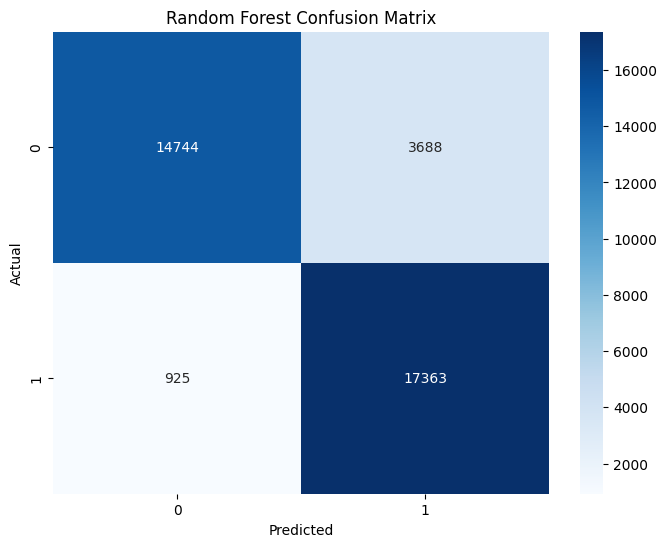

In [ ]:
# Confusion matrix
conf_matrix_RF = confusion_matrix(y_test, y_pred_RF)
plot_confusion_matrix(conf_matrix_RF, 'Random Forest Confusion Matrix')

### **CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

# Build the Convolutional Neural Network (CNN)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with one neuron for binary classification

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add EarlyStopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with more validation data
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

# Predict and evaluate
y_pred_probs = model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions
print("CNN Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix')
plt.show()

In [ ]:
# Plot training & validation loss and accuracy values in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot training & validation loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax1.set_xlim([1, len(history.history['loss'])])  # Set x-axis limit to start from 1

# Plot training & validation accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
ax2.set_xlim([1, len(history.history['accuracy'])])  # Set x-axis limit to start from 1

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>

### **XGBoost**

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90     18353
           1       0.97      0.91      0.94       296
           2       0.90      0.97      0.93     25849

    accuracy                           0.92     44498
   macro avg       0.94      0.91      0.92     44498
weighted avg       0.92      0.92      0.92     44498



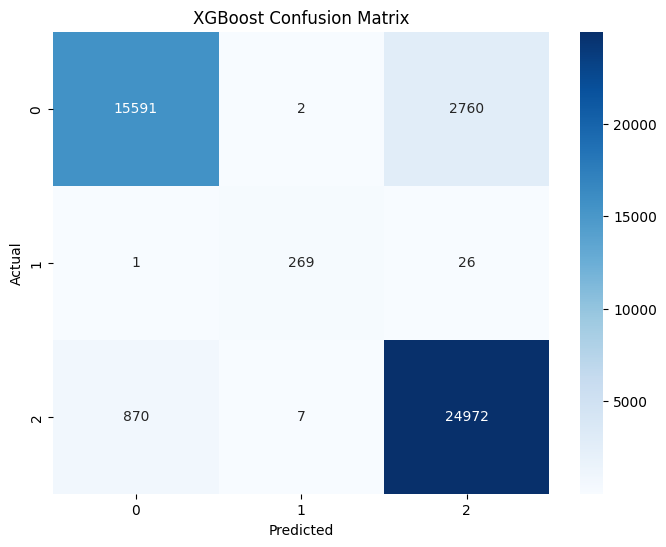

In [ ]:
import xgboost as xgb

# Train the model
XGB_model = xgb.XGBClassifier(random_state=42)
XGB_model.fit(X_train, y_train)
y_pred_XGB = XGB_model.predict(X_test)

conf_matrix_XGB = confusion_matrix(y_test, y_pred_XGB)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_XGB))

# Confusion matrix
conf_matrix_XGB = confusion_matrix(y_test, y_pred_XGB)
plot_confusion_matrix(conf_matrix_XGB, 'XGBoost Confusion Matrix')


## **Compare**

In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     129146
Incident     91798
Problem       1545
Name: count, dtype: int64

In [ ]:
report_dict = {}
report_dict['Random Forest'] = classification_report(y_test, y_pred_RF, output_dict=True)
report_dict['Naive Bayes'] = classification_report(y_test, y_pred_NB, output_dict=True)
report_dict['XGBoost'] = classification_report(y_test, y_pred_XGB, output_dict=True)
report_dict['MLP Classifier'] = classification_report(y_test, y_pred_MLP, output_dict=True)

Metric          f1-score  precision    recall
Model                                        
MLP Classifier  0.843325   0.846788  0.845296
Naive Bayes     0.730280   0.760682  0.718796
Random Forest   0.887981   0.896533  0.890040
XGBoost         0.916850   0.919659  0.917614


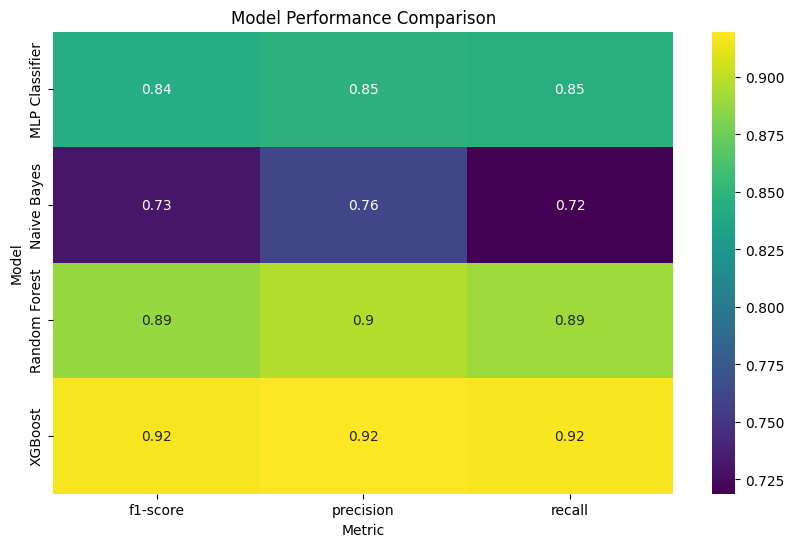

In [ ]:
# Extract relevant metrics and create a DataFrame
metrics = ['precision', 'recall', 'f1-score']
rows = []

for model_name, report in report_dict.items():
    for metric in metrics:
        avg_metric = report['weighted avg'][metric]
        rows.append({'Model': model_name, 'Metric': metric, 'Score': avg_metric})

performance_df = pd.DataFrame(rows)

# Pivot the DataFrame for better visualization
performance_pivot = performance_df.pivot(index='Model', columns='Metric', values='Score')
print(performance_pivot)

# Plot the performance table
plt.figure(figsize=(10, 6))
sns.heatmap(performance_pivot, annot=True, cmap='viridis')
plt.title('Model Performance Comparison')
plt.show()